notebook that was used to generate figures for paper

In [1]:
import scipy
import scipy.sparse, scipy.stats
import numpy
import os
import re
import multiprocessing
import subprocess
import pickle
import matplotlib.pyplot as plt 
import matplotlib.pyplot
import time
import statistics
import sklearn
import statsmodels , statsmodels.api
import itertools
import random
import math

In [2]:
def moving_integration (values, window):
    weights = numpy.repeat(1.0, window)
    sma = numpy.convolve(values, weights, 'same')
    return sma
def moving_average (values, window):
    weights = numpy.repeat(1.0, window)/window
    sma = numpy.convolve(values, weights, 'same')
    return sma

In [3]:
with open("../testdata/mumbach_27ac_0.1alldata.pickle","rb") as picklefile:
    CSR_mat,frag_index,frag_prop,frag_amount,valid_chroms,chroms_offsets,smoothed_diagonal, refined_peaks ,quick_peaks, peak_p_vals , peaks_q_vals,expected_background = pickle.load(picklefile)

In [4]:
#distance from restriction site bias
validpairs_file="C:\\Users\\MDEFSCS4\\Documents\\GitHub\\domain_caller\\testdata\\NaiveT_27ac_B1_T1\\NaiveT_27ac_B1_T1_trim_genome.bwt2pairs.validPairs"
distances=[]
with open(validpairs_file, "r") as validpairs:
    for line in validpairs:
        distances.append(int(line.split()[7]))


In [5]:
%matplotlib qt
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.hist(distances, bins=100, range=(0,600), density=True,color="#3F5D7D")
plt.title("Distance from restriction cut site \nNaiveT_27ac_B1_T1", fontsize=17)    
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("bp distance from cut site", fontsize=14)
ax.tick_params(labelsize=13)
fig.show()

In [16]:
#distribution of reads frequency
%matplotlib qt

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.hist(smoothed_diagonal, bins=100, range=(0,100),density=True,color="#3F5D7D")
plt.title("Distribution of reads frequency by fragment \nNaiveT_27ac_B1_T1", fontsize=17)    
plt.ylabel("frequency", fontsize=14)
plt.xlabel("number of reads per bin", fontsize=14)
ax.tick_params(labelsize=13)
fig.show()

In [95]:
# distribution of p values after binomial model
%matplotlib qt
fig = matplotlib.pyplot.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
plt.title("Negative binomial test p-value distribution \nNaiveT_27ac_B1_T1", fontsize=17)    
plt.ylabel("frequency", fontsize=14)
plt.xlabel("p-values", fontsize=14)
ax.tick_params(labelsize=13)
ax.hist(peak_p_vals, bins=20, range=(0,1),density=True,color="#3F5D7D")
fig.show()

In [6]:
#tired of rewriting this bit everytime
def extract_data(filename):
    with open(filename) as data:
        graph_data_x=[]
        graph_data_y=[]
        for line in data:
            line_info = line.split()
            graph_data_x.append(int(line_info[2])-int(line_info[1]))
            graph_data_y.append(float(line_info[6]))
    return (graph_data_x,graph_data_y)


def cal_True_pos(graph_data_y):
    true_pos = []
    real=0
    fake=0
    for i in graph_data_y:
        if i>0:
            real+=1
        else:
            fake+=1
        true_pos.append(real/(real+fake))
    return true_pos

bedtools annotate -counts -i mumbach_27ac_0.001peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/T_cell_0.001_final_peaks.bed
bedtools annotate -counts -i mumbach_27ac_0.01peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/T_cell_0.01_final_peaks.bed
bedtools annotate -counts -i mumbach_27ac_0.1peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/T_cell_0.10_final_peaks.bed

bedtools annotate -counts -i mumbach_27ac.hichipper-noX.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
awk '{SUM += $3-$2} END {print SUM}' mumbach_27ac.hichipper-noX.bed

bedtools annotate -counts -i mumbach_27ac.hichipper-noX-ALL_READS.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
awk '{SUM += $3-$2} END {print SUM}' mumbach_27ac.hichipper-noX-ALL_READS.bed


for fithichip the peaks are really small and sometimes multiple peaks will overlap the same reference peak.
this makes it difficult to have fair comparisons, although the false positive rate is definitely very high.

total area covered will be very little because peaks are really small. best would be to compute false positive rate, but then multiple peaks are calling the same peak. I will leave it anyway because the rate will be really low anyway. but to compute the number of peaks covered from reference I can't just sum it like i did for the others. 
this will count peaks not called. peaks called will be tot_peaks_in_reference-x (50328-27071 = 23257)
bedtools annotate -counts -i T_helper_replicated_peaks.bed -files T_cells_fithichipMACS2-noX.narrowPeak | cut -f4,4 | grep "0" | wc -l
this will count the false positives. true positive rate =tot_peaks_called-x/tot_peaks_called (82111-53954/82111=0.3429)
bedtools annotate -counts -i T_cells_fithichipMACS2-noX.narrowPeak -files T_helper_replicated_peaks.bed | cut -f11,11 | grep "0" | wc -l


#####not used result 17966, 32362 peaks called
bedtools slop -i T_cells_fithichipMACS2-noX.narrowPeak -b 1000 -g chrom_hg38.sizes > temp 
bedtools annotate -counts -i T_helper_replicated_peaks.bed -files temp | cut -f4,4 | grep "0" | wc -l
82111-43648/82111=0.4684
bedtools annotate -counts -i temp -files T_helper_replicated_peaks.bed | cut -f11,11 | grep "0" | wc -l

In [93]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.001_final_peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.01_final_peaks.bed")


ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.10_final_peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.1", linewidth=4)

ax.scatter(40577,31882,color="black",label="Hichipper Self",s=100)
#hichipper all
ax.scatter(130426,39668,color="red",label="Hichipper All",s=100)

ax.scatter(82110,23257,color="purple",label="fitHiChIP",s=100)

#0.05
#ax.scatter(40578,31882)




plt.title("Coverage of peaks from reference E038 Naive T cells", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)", fontsize=14)
plt.xlabel("Peaks called", fontsize=14)
plt.legend(loc='lower right')
#plt.legend(("FDR=0.001","FDR=0.01","FDR=0.1","Hichipper Self","Hichipper All","fitHiChIP"),loc='lower right')
ax.tick_params(labelsize=13)


fig.show()

In [30]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.001_final_peaks.bed")

ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.01_final_peaks.bed")


ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.10_final_peaks.bed")

ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.1", linewidth=4)

ax.scatter(122355537,31882,color="black",label="Hichipper Self",s=100)
#hichipper all
ax.scatter(530010358,39668,color="red",label="Hichipper All",s=100)

ax.scatter(38449282,23257,color="purple",label="fitHiChIP",s=100)

#0.05
#ax.scatter(40578,31882)



plt.title("Coverage of peaks from reference E038 Naive T cells", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)", fontsize=14)
plt.xlabel("Genome covered(Gbp)", fontsize=14)
plt.legend(loc='lower right')
#plt.legend(("FDR=0.001","FDR=0.01","FDR=0.1","Hichipper Self","Hichipper All","fitHiChIP"),loc='lower right')

ax.tick_params(labelsize=13)



fig.show()

In [96]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.bar(x="hichipper Self",height=31882)
ax.bar(x="hichipper All",height=39668)
ax.bar(x="fitHiChIP",height=23257)
graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.001_final_peaks.bed")

ax.bar(x="FDR=0.001",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.01_final_peaks.bed")

ax.bar(x="FDR=0.01",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.10_final_peaks.bed")

ax.bar(x="FDR=0.1",height=sum(graph_data_y))


plt.title("Peaks from reference E038 Naive T cells re-called", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)")

ax.tick_params(labelsize=10)



fig.show()


In [7]:
%matplotlib qt


fig = matplotlib.pyplot.figure(figsize=(12,6))
ax= fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.001_final_peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.01_final_peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/T_cell_0.10_final_peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.1", linewidth=4)


#bedtools annotate -counts -i mumbach_27ac.hichipper-noX.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
ax.scatter(31882,(40578-20860)/40578,color="black",label="Hichipper Self",s=100)
#number of peaks from reference called, peaks containing reference/total peaks called. just grep the zeros which mean not covering reference
#bedtools annotate -counts -i mumbach_27ac.hichipper-noX-ALL_READS.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
ax.scatter(39668,(130426-107653)/130426,color="red",label="Hichipper All",s=100)

ax.scatter(23257,(82111-53954)/82111,color="purple",label="fitHiChIP",s=100)


plt.title("True positive rate vs number of peaks recovered from reference (T-cells)", fontsize=17)    
plt.ylabel("True positive rate \n(peaks overlapping reference/total peaks called)", fontsize=12)
plt.xlabel("Peaks recovered from reference (n = 48803)\n(Sensitivity)", fontsize=12)
plt.legend(loc='lower left')
#plt.legend(("FDR=0.001","FDR=0.01","FDR=0.1","hichipper self","hichipper all","fitHiChIP"),loc='lower left')

plt.ylim(0,1)

ax.tick_params(labelsize=12)

fig.show()


0.48592833555128395

GM12878 FAILED FOR HICHIPPER ALL READS

bedtools annotate -counts -i GM12878_H3K27ac_0.001peaks.bed -files GM12878_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/GM12878_0.001_final_peaks.bed
bedtools annotate -counts -i GM12878_H3K27ac_0.01peaks.bed -files GM12878_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/GM12878_0.01_final_peaks.bed
bedtools annotate -counts -i GM12878_H3K27ac_0.1peaks.bed -files GM12878_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/GM12878_0.10_final_peaks.bed

bedtools annotate -counts -i GM12878_H3K27ac.hichipper-noX.bed -files GM12878_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
awk '{SUM += $3-$2} END {print SUM}' GM12878_H3K27ac.hichipper-noX.bed

bedtools annotate -counts -i GM12878_H3K27ac.hichipper-noX-ALL_READS.bed -files GM12878_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
awk '{SUM += $3-$2} END {print SUM}' GM12878_H3K27ac.hichipper-noX-ALL_READS.bed


for fithichip the peaks are really small and sometimes multiple peaks will overlap the same reference peak.
this makes it difficult to have fair comparisons, although the false positive rate is definitely very high.

total area covered will be very little because peaks are really small. best would be to compute false positive rate, but then multiple peaks are calling the same peak. I will leave it anyway because the rate will be really low anyway. but to compute the number of peaks covered from reference I can't just sum it like i did for the others. 
this will count peaks not called. peaks called will be tot_peaks_in_reference-x (57887-25042 = 32845)
bedtools annotate -counts -i GM12878_replicated_peaks.bed -files GM12878_fithichipMACS2-noX.narrowPeak | cut -f11,11 | grep "0" | wc -l
this will count the false positives. true positive rate =tot_peaks_called-x/tot_peaks_called (126472-85238/126472=0.3260)
bedtools annotate -counts -i GM12878_fithichipMACS2-noX.narrowPeak -files GM12878_replicated_peaks.bed | cut -f11,11 | grep "0" | wc -l


In [98]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.001_final_peaks.bed") 

ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.01_final_peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.10_final_peaks.bed")


ax.plot(numpy.array(graph_data_y).cumsum(),label="FDR=0.1", linewidth=4)

ax.scatter(67736,45863,color="black",label="Hichipper Self",s=100)

#hichipper all
#ax.scatter(530010358,39668,color="red")

#fithichip
ax.scatter(126472,32845,color="purple",label="fitHiChIP",s=100)




plt.title("Coverage of peaks from reference ENCODE GM12878", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 57888)", fontsize=14)
plt.xlabel("Peaks called", fontsize=14)
plt.legend(loc='lower right')
ax.tick_params(labelsize=13)
fig.show()

In [43]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.001_final_peaks.bed") 

ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.01_final_peaks.bed")

ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.10_final_peaks.bed")


ax.plot(numpy.array(graph_data_x).cumsum(),numpy.array(graph_data_y).cumsum(),label="FDR=0.1", linewidth=4)

ax.scatter(225817383,45863,color="black",label="Hichipper Self",s=100)

#hichipper all
#ax.scatter(530010358,39668,color="red")


ax.scatter(59789850,32845,color="purple",label="fitHiChIP",s=100)


plt.title("Coverage of peaks from reference ENCODE GM12878", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 57888)", fontsize=14)
plt.xlabel("Genome covered(bp)", fontsize=14)
plt.legend(loc='lower right')
ax.tick_params(labelsize=13)
fig.show()

In [25]:
%matplotlib qt

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)

ax.bar(x="hichipper Self",height=45863)
ax.bar(x="fitHiChIP",height=32845)
graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.001_final_peaks.bed") 


ax.bar(x="FDR=0.001",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.01_final_peaks.bed")

ax.bar(x="FDR=0.01",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.10_final_peaks.bed")

ax.bar(x="FDR=0.1",height=sum(graph_data_y))


plt.title("Peaks from reference ENCODE GM12878 re-called", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 57888)")



fig.show()


In [13]:
%matplotlib qt


fig = matplotlib.pyplot.figure(figsize=(12,6))
ax= fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.001_final_peaks.bed") 

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.001", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.01_final_peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.01", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/GM12878_0.10_final_peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="FDR=0.1", linewidth=4)


#bedtools annotate -counts -i GM12878_H3K27ac.hichipper-noX.bed -files GM12878_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
ax.scatter(45863,(67736-40726)/67736, color="black",label="Hichipper Self",s=100)
#bedtools annotate -counts -i GM12878_H3K27ac.hichipper-noX-ALL_READS.bed -files GM12878_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
#ax.scatter(39668,(130426-107653)/130426, color="red")
#hichipper all failed!

ax.scatter(32845,(126472-85238)/126472,color="purple",label="fitHiChIP",s=100)

plt.title("True positive rate vs number of peaks recovered from reference (GM12878)", fontsize=17)    
plt.ylabel("True positive rate \n(peaks overlapping reference/total peaks called)", fontsize=12)
plt.xlabel("Peaks recovered from reference (n = 57888)\n(Sensitivity)", fontsize=12)
plt.legend(loc='lower left')
ax.tick_params(labelsize=12)
plt.ylim(0,1)



fig.show()


In [ ]:
#stability using less reads
# my software still runs fine with only 100 million reads while hichipper looses a lot

bedtools annotate -counts -i NaiveT_27ac_B2_T1-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
26159
wc -l NaiveT_27ac_B2_T1-noX.anchors.bed
27660
bedtools annotate -counts -i NaiveT_27ac_B2_T2-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
26647
wc -l NaiveT_27ac_B2_T2-noX.anchors.bed
28884
bedtools annotate -counts -i NaiveT_27ac_B3_T1-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
24839
wc -l NaiveT_27ac_B3_T1-noX.anchors.bed
27600
bedtools annotate -counts -i NaiveT_27ac_B3_T2-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | paste -sd+ - | bc
25395
wc -l NaiveT_27ac_B3_T2-noX.anchors.bed
26141

bedtools annotate -counts -i NaiveT_27ac_B2_T1-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
10445
bedtools annotate -counts -i NaiveT_27ac_B2_T2-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
11424
bedtools annotate -counts -i NaiveT_27ac_B3_T1-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
11159
bedtools annotate -counts -i NaiveT_27ac_B3_T2-noX.anchors.bed -files T_helper_replicated_peaks.bed | cut -f4,4 | grep "0" | wc -l
9487

my software
bedtools annotate -counts -i NaiveT_27ac_B2_T1peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/NaiveT_27ac_B2_T1peaks.bed

bedtools annotate -counts -i NaiveT_27ac_B2_T2peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/NaiveT_27ac_B2_T2peaks.bed

bedtools annotate -counts -i NaiveT_27ac_B3_T1peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/NaiveT_27ac_B3_T1peaks.bed

bedtools annotate -counts -i NaiveT_27ac_B3_T2peaks.bed -files T_helper_replicated_peaks.bed | sort -k6,6 -r -g > coverage_data/NaiveT_27ac_B3_T2peaks.bed






In [10]:
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T1peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="B2_T1", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T2peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="B2_T2", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T1peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="B3_T1", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T2peaks.bed")

ax.plot(numpy.array(graph_data_y).cumsum(),label="B3_T2", linewidth=4)



ax.scatter(27660,26159,label="Hichipper B2_T1",s=100)
ax.scatter(28884,26647,label="Hichipper B2_T2",s=100)
ax.scatter(27600,24839,label="Hichipper B3_T1",s=100)
ax.scatter(26141,25395,label="Hichipper B3_T2",s=100)

plt.title("Coverage of peaks from reference E038 Naive T cells", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)", fontsize=14)
plt.xlabel("Peaks called", fontsize=14)
plt.legend(loc='lower right')
#plt.legend(("FDR=0.001","FDR=0.01","FDR=0.1","Hichipper Self","Hichipper All","fitHiChIP"),loc='lower right')
ax.tick_params(labelsize=13)
fig.show()

In [11]:
#number of peaks covered
%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.bar(height=26159,x="Hichipper B2_T1")
ax.bar(height=26647,x="Hichipper B2_T2")
ax.bar(height=24839,x="Hichipper B3_T1")
ax.bar(height=25395,x="Hichipper B3_T2")


graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T1peaks.bed")

ax.bar(x="B2_T1",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T2peaks.bed")

ax.bar(x="B2_T2",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T1peaks.bed")

ax.bar(x="B3_T1",height=sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T2peaks.bed")
ax.bar(x="B3_T2",height=sum(graph_data_y))




plt.title("Peaks from reference E038 Naive T cells re-called", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)", fontsize=12)
ax.tick_params(labelsize=12)
plt.xticks(rotation=75)
fig.subplots_adjust(bottom=0.3)

fig.show()


In [14]:
#same as above but boxplot
#number of peaks covered
import seaborn as sns

%matplotlib qt

fig = matplotlib.pyplot.figure(figsize=(8,5))
ax = fig.add_subplot(111)


mysoft_data=[]
graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T1peaks.bed")

mysoft_data.append(sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T2peaks.bed")

mysoft_data.append(sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T1peaks.bed")

mysoft_data.append(sum(graph_data_y))

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T2peaks.bed")
mysoft_data.append(sum(graph_data_y))

sns.swarmplot(data=((26159,26647,24839,25395),mysoft_data),ax=ax,size=8)


plt.title("Peaks from reference E038 Naive T cells re-called", fontsize=17)    
plt.ylabel("Peaks of reference covered (n = 48803)")
plt.xticks((0,1),("hichipper","mysoftware"))

plt.ylim(20000,37000)
fig.show()


In [12]:
# false discovery rate estimation

%matplotlib qt


fig = matplotlib.pyplot.figure(figsize=(12,6))
ax= fig.add_subplot(111)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T1peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="B2_T1", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B2_T2peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="B2_T2", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T1peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="B3_T1", linewidth=4)

graph_data_x,graph_data_y = extract_data("../testdata/coverage_data/NaiveT_27ac_B3_T2peaks.bed")

true_pos = cal_True_pos(graph_data_y)

ax.plot(numpy.array(graph_data_y).cumsum(),true_pos,label="B3_T2", linewidth=4)

#(peaks recovered, (total peaks called - peaks with zero)/total peaks called)
ax.scatter(26159,(27660-10445)/27660,label="Hichipper B2_T1",s=100)
ax.scatter(26647,(28884-11424)/28884,label="Hichipper B2_T1",s=100)
ax.scatter(24839,(27600-11159)/27600,label="Hichipper B2_T1",s=100)
ax.scatter(25395,(26141-9487)/26141,label="Hichipper B2_T1",s=100)



plt.title("True positive rate vs number of peaks recovered from reference (T-cells)", fontsize=17)    
plt.ylabel("True positive rate \n(peaks overlapping reference/total peaks called)", fontsize=12)
plt.xlabel("Peaks recovered from reference (n = 48803)\n(Sensitivity)", fontsize=12)
plt.legend(loc='lower left')

plt.ylim(0,1)

ax.tick_params(labelsize=12)

fig.show()


In [59]:
# fragment size bias
# self-circle and dangling ends pairs only. Plot lowess fit of fragment size to number of reads
#maybe integrate the thing for the maximum and minimum size below as well
res_frag_mat = scipy.sparse.load_npz('../../domain_caller/testdata/sparse_matrix_mumbach.npz')
SC_DE_pairs = res_frag_mat.diagonal(k=0) #self circle and dangling end pairs
sizes=[]
for i in frag_prop:
    sizes.append(i[3])
    
sizes_sub, SC_DE_pairs_sub = zip(*random.sample(list(zip(sizes, SC_DE_pairs)), 50000))
y = statsmodels.api.nonparametric.lowess(SC_DE_pairs_sub, sizes_sub,return_sorted=False,frac=0.2,delta=10.0)
%matplotlib qt
fig, ax = matplotlib.pyplot.subplots()
ax.scatter(sizes_sub,y)
fig.show()

In [65]:
# fragment size bias with our method FOR PAPER
# this should be exactly what our software is doing
lengths = [x[3] for x in frag_prop] 
group_lengths = moving_integration(lengths,2)  ###changed to 2, so the 2 fragments within
min_allowed_size = math.floor(numpy.percentile(group_lengths, 1))
max_allowed_size = math.floor(numpy.percentile(group_lengths, 99))
# add 1s to quick peaks to exclude them from the noise modelling
noise_filter = quick_peaks.copy()
for i in range(len(group_lengths)):
    if group_lengths[i] > max_allowed_size or group_lengths[i] < min_allowed_size:
        noise_filter[i] = 1

# select only the bits that give you noise. On which to model stuff
noise_lengths = list(itertools.compress(group_lengths, [not i for i in noise_filter]))
noise_diagonal = list(itertools.compress(smoothed_diagonal, [not i for i in noise_filter]))

idx = numpy.random.choice(len(noise_lengths), size=200000, replace=False)
subset_lengths = [noise_lengths[n] for n in idx]
subset_diagonal = [noise_diagonal[n] for n in idx]
# find lowess prediction
predicted_stuff = statsmodels.api.nonparametric.lowess(subset_diagonal, subset_lengths,return_sorted=True, frac=0.4 , delta=3.0 ) 
predicted_lengths = list(zip(*predicted_stuff))[0]
predicted_diagonals = list(zip(*predicted_stuff))[1]

%matplotlib qt
fig, ax = matplotlib.pyplot.subplots(figsize=(8,5))
ax.scatter(predicted_lengths,predicted_diagonals)

plt.title("Fragment size bias - lowess fit \n Naive T cells", fontsize=17)
plt.xlabel("Size of sum of fragments between restriction sites (bp)")
plt.ylabel("Number of reads expected from lowess fit (reads)")

fig.show()

In [11]:
# fit on the diagonal without smoothing. using the size of the restriction fragment before and after
from context import hichip_tool

from hichip_tool import sparse_to_peaks

non_smooth_diagonal = sparse_to_peaks.extract_diagonal(CSR_mat,2)[0]
### added now so maybe not working
min_allowed_size = math.floor(numpy.percentile(group_lengths, 1))
max_allowed_size = math.floor(numpy.percentile(group_lengths, 99))

noise_filter = [0]*len(group_lengths)
for i in range(len(group_lengths)):
    if group_lengths[i] > max_allowed_size or group_lengths[i] < min_allowed_size:
        noise_filter[i] = 1

# select only the bits that give you noise. On which to model stuff
noise_lengths = list(itertools.compress(group_lengths, [not i for i in noise_filter]))
noise_diagonal = list(itertools.compress(non_smooth_diagonal, [not i for i in noise_filter]))

###
idx = numpy.random.choice(len(noise_lengths), size=200000, replace=False)
subset_lengths = [noise_lengths[n] for n in idx]
subset_diagonal = [noise_diagonal[n] for n in idx]
# find lowess prediction
predicted_stuff = statsmodels.api.nonparametric.lowess(subset_diagonal, subset_lengths,return_sorted=True, frac=0.4 , delta=3.0 ) 
predicted_lengths = list(zip(*predicted_stuff))[0]
predicted_diagonals = list(zip(*predicted_stuff))[1]

%matplotlib qt
fig, ax = matplotlib.pyplot.subplots()
ax.scatter(predicted_lengths,predicted_diagonals)
fig.show()

In [ ]:
#distance bias

In [ ]:
#uncut fragments

In [27]:
from context import hichip_tool

from hichip_tool import sparse_to_peaks

print(sparse_to_peaks.extract_diagonal(CSR_mat,2)[1])
print(round(sum(smoothed_diagonal)/3)) # don't remember what this is

80867062.0
80867062.0


In [13]:
sum(res_frag_mat.diagonal(k=0)) + sum(res_frag_mat.diagonal(k=1))*2 

NameError: name 'res_frag_mat' is not defined

In [33]:
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()

82782600.0

ValueError: At least one argument from "cellColours" or "cellText" must be provided to create a table.

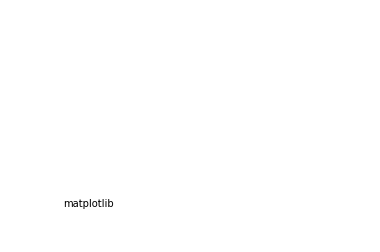

In [3]:

fig, ax = matplotlib.pyplot.subplots()

ax.text(0.1, 0.1, 'matplotlib')
ax.axis("off")
ax.table(cellText=None, cellColours=None,
      cellLoc='right', colWidths=None,
      rowLabels=None, rowColours=None, rowLoc='left',
      colLabels=None, colColours=None, colLoc='center',
      loc='bottom', bbox=None)
fig.show()

In [9]:
%matplotlib qt
fig, ax = matplotlib.pyplot.subplots(figsize=(8,5),frameon=False)
ax.axis("off")
ax.text(0.5, 0.95, 'Thank you for using my software',
        horizontalalignment='center',
        verticalalignment='center',
       fontsize=18)
ax.text(0.5, 0.7, 'Number of reads used for peak calling : {}'.format(21312232),
        horizontalalignment='center',
        verticalalignment='center',
       fontsize=16)
ax.text(0.5, 0.5, 'Number of peaks called : {}'.format(21312232),
        horizontalalignment='center',
        verticalalignment='center',
       fontsize=16)


fig.show()

In [33]:
sum([x for x,y in zip(smoothed_diagonal, refined_peaks) if y==1])/3/80867062.0

0.5848554013252021

In [21]:
from context import hichip_tool

from hichip_tool import quality_report

quality_report.quality_report(peak_p_vals,refined_peaks, smoothed_diagonal, "F:\\psa_functional_genomics\\Mumbach_other_cells\\data\\my_software_GM_sub", "GM_EIGHTH")